In [95]:
import pandas as pd 
import numpy as np
#tdqm = progress bar
from tqdm import tqdm
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [96]:
# Number of rows
nrows = 10000
# Chunksize = 10000 
chunksize = 10000
# Vitou's path
path = 'C:/Users/Vitou/Downloads/train.csv'
# Muna's path
#path = '/Users/muna/Development/DataScience/new-york-city-taxi-fare-prediction/train.csv'
# Columns to read from the data
# Todo :split date into meaningful data
# cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','fare_amount']
cols = ['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','fare_amount']

#list to hold the batch dataframe
df_list = []

for df_chunk in tqdm(pd.read_csv(path,usecols=cols, chunksize=chunksize,nrows=nrows)):
    df_list.append(df_chunk)
    
# Merge all dataframes into one dataframe
data = pd.DataFrame()
data = pd.concat(df_list)
# # Delete the dataframe list to release memory
del df_list, df_chunk

1it [00:00, 83.33it/s]


### Given a dataframe, add two new features 'abs_diff_longitude' and 'abs_diff_latitude' reprensenting the "Manhattan vector" from the pickup location to the dropoff location.

In [97]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [98]:
%%time
add_travel_vector_features(data)
print(data[::10])

      fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0             4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
10            5.3  2012-04-08 07:30:50 UTC        -73.996335        40.737142   
20           10.5  2010-09-07 13:18:00 UTC        -73.985382        40.747858   
30            5.5  2014-02-19 16:03:00 UTC        -73.976075        40.752422   
40            8.1  2011-03-29 15:39:49 UTC        -73.984267        40.744961   
...           ...                      ...               ...              ...   
9950         12.5  2013-03-30 19:01:43 UTC        -73.968147        40.800429   
9960         12.5  2011-08-13 23:52:18 UTC        -73.940035        40.840880   
9970          6.9  2009-12-29 16:29:00 UTC        -73.984122        40.759905   
9980          5.5  2012-11-09 17:47:00 UTC        -74.005310        40.751275   
9990         20.5  2013-04-29 17:01:00 UTC        -73.946900        40.784247   

      dropoff_longitude  dr

### Let's take a look at the data

In [99]:
%%time
data.describe(include='all')

Wall time: 47 ms


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
count,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
unique,NaN,9985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2009-05-10 17:57:00 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,11.235464,NaN,-72.466660,39.920448,-72.474094,39.893281,1.644700,0.103411,0.098102
std,9.584258,NaN,10.609729,7.318932,10.579732,6.339919,1.271229,2.429089,3.824894
min,-2.900000,NaN,-74.438233,-74.006893,-74.429332,-73.994392,0.000000,0.000000,0.000000
25%,6.000000,NaN,-73.992058,40.734547,-73.991112,40.735230,1.000000,0.005734,0.006715
50%,8.500000,NaN,-73.981758,40.752693,-73.980083,40.753738,1.000000,0.012453,0.013940
75%,12.500000,NaN,-73.966925,40.767694,-73.963504,40.768186,2.000000,0.024149,0.026681


###  Check for missing values


In [100]:
%%time
# Checking for missing values
data.isnull().sum()

Wall time: 2 ms


fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
abs_diff_longitude    0
abs_diff_latitude     0
dtype: int64

### We drop all the rows with the missing values

In [101]:
%%time
data = data.dropna(how = 'any', axis = 'rows')

Wall time: 3 ms


###  From the description above, some of the fare_amount have negative values. We are going to remove all negative fare_amounts

In [102]:
%%time
data = data[(data['fare_amount'] > 0)]


Wall time: 2 ms


In [103]:
%%time
data.describe()

Wall time: 21 ms


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
count,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000
mean,11.238252,-72.466375,39.920296,-72.473810,39.893123,1.644829,0.103431,0.098122
std,9.583189,10.610771,7.319656,10.580772,6.340543,1.271324,2.429332,3.825276
min,0.010000,-74.438233,-74.006893,-74.429332,-73.994392,0.000000,0.000000,0.000000
25%,6.000000,-73.992056,40.734564,-73.991109,40.735235,1.000000,0.005734,0.006716
50%,8.500000,-73.981758,40.752695,-73.980083,40.753740,1.000000,0.012460,0.013944
75%,12.500000,-73.966934,40.767696,-73.963512,40.768187,2.000000,0.024151,0.026687
max,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000,74.010230,360.304405


### In further observation, we have pickup_longitude, puckup_latitiude, dropoff_longitude and dropoff_latitude. We can calculate the distance

In [104]:
# Function that calculates distance between pickup location and dropoff location
def get_distance(lat1,lon1,lat2,lon2):
    r = 6378 # earth's radius
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = r*c
    
    return distance

In [105]:
%%time
# Add new cloumn "distance" to the data
data['distance'] = get_distance(data.pickup_latitude, data.pickup_longitude, 
                                      data.dropoff_latitude, data.dropoff_longitude)

Wall time: 5 ms


In [106]:
data.describe(include='all')

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance
count,9998.000000,9998,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000
unique,NaN,9983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2009-05-10 17:57:00 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,11.238252,NaN,-72.466375,39.920296,-72.473810,39.893123,1.644829,0.103431,0.098122,12.730622
std,9.583189,NaN,10.610771,7.319656,10.580772,6.340543,1.271324,2.429332,3.825276,276.037164
min,0.010000,NaN,-74.438233,-74.006893,-74.429332,-73.994392,0.000000,0.000000,0.000000,0.000000
25%,6.000000,NaN,-73.992056,40.734564,-73.991109,40.735235,1.000000,0.005734,0.006716,1.207945
50%,8.500000,NaN,-73.981758,40.752695,-73.980083,40.753740,1.000000,0.012460,0.013944,2.122888
75%,12.500000,NaN,-73.966934,40.767696,-73.963512,40.768187,2.000000,0.024151,0.026687,3.879478


### We split up the pickup datetime into more meaningful features

In [107]:
def split_datetime(df):
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
        df['year'] = df['pickup_datetime'].dt.year
        df['month'] = df['pickup_datetime'].dt.month
        df['day'] = df['pickup_datetime'].dt.day
        df['hour'] = df['pickup_datetime'].dt.hour
        df['dayOfWeek'] = df['pickup_datetime'].dt.dayofweek
        df = df.drop(columns="pickup_datetime")
        return df

In [108]:
split_datetime(data)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,1.031896,2009,6,15,17,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,8.459418,2010,1,5,16,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,1.391052,2011,8,18,0,3
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,2.802346,2012,4,21,4,5
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,2.001353,2010,3,9,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11.7,-73.988277,40.748970,-73.963712,40.773958,2,0.024565,0.024988,3.468019,2011,10,26,10,2
9996,5.7,-74.002112,40.748727,-73.992467,40.756252,1,0.009645,0.007525,1.167555,2011,12,16,15,4
9997,12.0,-73.992093,40.729071,-73.974470,40.763050,2,0.017623,0.033979,4.063960,2013,11,16,22,5
9998,6.5,-73.992548,40.735652,-73.998802,40.723085,1,0.006254,0.012567,1.495094,2010,1,28,11,3


In [109]:
%%time
data.head()

Wall time: 0 ns


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,1.031896,2009,6,15,17,0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,8.459418,2010,1,5,16,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,1.391052,2011,8,18,0,3
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,2.802346,2012,4,21,4,5
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,2.001353,2010,3,9,7,1


In [110]:
feature_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','abs_diff_longitude',
                'abs_diff_latitude','distance','year','month','day','hour']

X = data[feature_cols] 
y = data['fare_amount']

In [111]:
def get_input_matrix(df):
    return np.column_stack((df.passenger_count, 
                            df.distance,df.abs_diff_longitude, df.abs_diff_latitude,
                            df.year,df.month,df.day,df.hour,df.dayOfWeek, 
                            df.abs_diff_longitude, df.abs_diff_latitude, 
                            np.ones(len(df))))

In [112]:
X_train = get_input_matrix(data)
y_train =  np.array(data['fare_amount'])

test_df = pd.read_csv('C:/Users/Vitou/Downloads/test.csv')

#add year, month, day, hour, dayOfWeek to the test.csv
split_datetime(test_df)

#add distance to the test.csv
test_df['distance'] = get_distance(test_df.pickup_latitude, test_df.pickup_longitude, 
                                      test_df.dropoff_latitude, test_df.dropoff_longitude)
add_travel_vector_features(test_df)

X_test = get_input_matrix(test_df)

(w, _, _, _) = np.linalg.lstsq(X_train, y_train, rcond = None)

# Predict fare_amount on the test set using our model (w) trained on the training set.
y_test = np.matmul(X_test, w).round(decimals = 2)

### Fix ValueError: Unknown label type: 'continuous'. preprocessing.LabelEncoder() - convert string or float values to 0 .. n classes.

In [134]:
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
y_encoded = lab_enc.fit_transform(y)
y_test_encoded = lab_enc.fit_transform(y_test)
print(y_train)
print(y_train_encoded)

[ 4.5 16.9  5.7 ... 12.   6.5 10.5]
[11 93 18 ... 64 25 54]


### Classifications and Regressions

In [114]:
%%time
my_linreg = LinearRegression()
my_linreg.fit(X_train, y_train)
y_prediction_lr = my_linreg.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_prediction_lr)
rmse_lr = np.sqrt(mse)
print('Linear Regression:'+str(rmse_lr))

Linear Regression:0.002847980401721707
Wall time: 6 ms


In [115]:
%%time
my_logreg = LogisticRegression()
my_logreg.fit(X_train, y_train_encoded)
y_prediction_log = my_logreg.predict(X_test)
mse_log = metrics.mean_squared_error(y_test, y_prediction_log)
rmse_log = np.sqrt(mse_log)
print('Logistic Regression: '+str(rmse_log))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic Regression: 18.319215021265514
Wall time: 20.6 s


In [116]:
%%time
my_decisiontree = DecisionTreeClassifier(random_state=5)
my_decisiontree.fit(X_train, y_train_encoded)
y_prediction = my_decisiontree.predict(X_test)
mse_dt = metrics.mean_squared_error(y_test, y_prediction)
rmse_dt = np.sqrt(mse_dt)
print('Decision Tree: '+str(rmse_dt))

Decision Tree: 76.99210091095757
Wall time: 512 ms


In [117]:
%%time
my_RandomForest = RandomForestClassifier(n_estimators = 10, bootstrap = True, random_state=3)
my_RandomForest.fit(X_train, y_train_encoded)
y_prediction = my_RandomForest.predict(X_test)
mse_rf = metrics.mean_squared_error(y_test, y_prediction)
rmse_rf = np.sqrt(mse_rf)
print('Random Forest: '+str(rmse_rf))

Random Forest: 68.9444792875279
Wall time: 1.47 s


### CROSS VALIDATIONS

In [118]:
%%time
score_list_lr = cross_val_score(my_linreg, X, y, cv=10)
score_lr = abs(score_list_lr).mean()
print('Linear Regression: '+str(score_lr))

Linear Regression: 0.4537109064108785
Wall time: 63.6 ms


In [119]:
%%time
score_list_log = cross_val_score(my_logreg, X, y_encoded, cv=10)
score_log = abs(score_list_log).mean()
print('Logistic Regression: '+str(score_log))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logi

Logistic Regression: 0.0477301312654128
Wall time: 3min 6s


In [120]:
%%time
score_list_dt = cross_val_score(my_decisiontree, X, y_encoded, cv=10)
score_dt = abs(score_list_dt).mean()
print('Decision Tree: '+str(score_dt))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Decision Tree: 0.09180465313526268
Wall time: 5.89 s


In [121]:
%%time
score_list_rf = cross_val_score(my_RandomForest, X, y_encoded, cv=10)
score_rf  = abs(score_list_rf ).mean()
print('Random Forest: '+str(score_rf))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Random Forest: 0.10569232735591116
Wall time: 13.8 s


# Plots

In [122]:
from sklearn import metrics
y_predict_prob_log = my_logreg.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test_encoded, y_predict_prob_log[:,1], pos_label=1)

print(fpr)
print(tpr)

[0.00000000e+00 1.00877635e-04 4.90467063e-01 4.90467063e-01
 6.63270453e-01 6.63472208e-01 7.02410975e-01 7.02612731e-01
 7.91082417e-01 7.91485928e-01 8.18319379e-01 8.18521134e-01
 8.21950973e-01 8.22253606e-01 8.43639665e-01 8.44244931e-01
 8.64218703e-01 8.64420458e-01 9.24442651e-01 9.24644406e-01
 1.00000000e+00]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [123]:
# AUC:
AUC = metrics.auc(fpr, tpr)
print(AUC)

0.5095329365479673


### ROC Curve

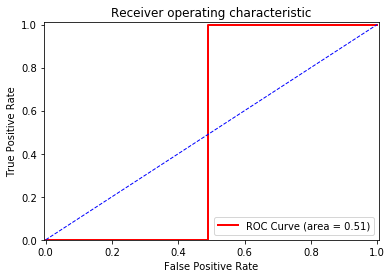

In [124]:
# Importing the "pyplot" package of "matplotlib" library of python to generate 
# graphs and plot curves:
import matplotlib.pyplot as plt

# The following line will tell Jupyter Notebook to keep the figures inside the explorer page 
# rather than openng a new figure window:
%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

### RSME Plot

Text(0.5, 1.0, 'RMSE Values')

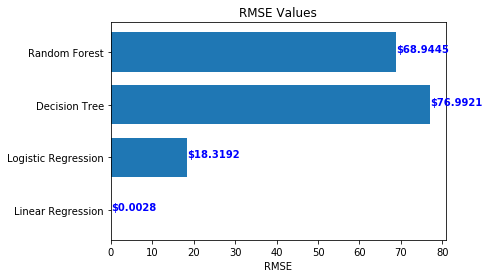

In [135]:
fig, ax = plt.subplots()
y_axis = ('Linear Regression','Logistic Regression','Decision Tree','Random Forest')
y_pos = np.arange(len(y_axis))
width = 0.75 
x_axis = (round(rmse_lr,4),round(rmse_log,4),round(rmse_dt,4),round(rmse_rf,4))
ax.barh(y_pos, x_axis, width,align='center')
for i, v in enumerate(x_axis):
    ax.text(v, i, '$'+str(v), color='blue', fontweight='bold')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_axis)
ax.set_xlabel('RMSE')
ax.set_title('RMSE Values')

### Cross Validation Plot

Text(0.5, 1.0, 'Cross Validation Values')

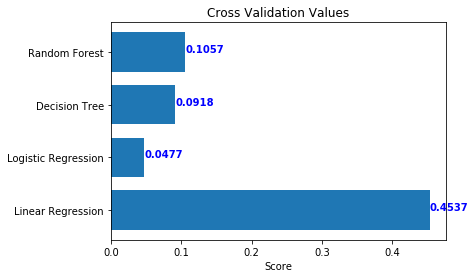

In [131]:
fig, ax = plt.subplots()
y_axis = ('Linear Regression','Logistic Regression','Decision Tree','Random Forest')
y_pos = np.arange(len(y_axis)) 
x_axis = (round(score_lr,4),round(score_log,4),round(score_dt,4),round(score_rf,4))
ax.barh(y_pos, x_axis, width,align='center')
for i, v in enumerate(x_axis):
    ax.text(v, i, str(v), color='blue', fontweight='bold')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_axis)
ax.set_xlabel('Score')
ax.set_title('Cross Validation Values')